This notebook provides a short sample on how to evaluate your trained model. We will continue from our previous notebook `03_` which has trained a working MLP. 

The complete evaluation script can be found in the root directory of the repository `eval.py`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import yaml
import numpy as np
import pandas as pd
from collections import defaultdict
from pathlib import Path
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
import lightning.pytorch as pl
from lightning.pytorch import loggers as pl_loggers
from lightning.pytorch.callbacks import ModelCheckpoint
pl.seed_everything(42)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context='paper')

import sys
sys.path.append('..')

from chaosbench import dataset, config, utils, criterion
from chaosbench.models import mlp, model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

[rank: 0] Global seed set to 42


First we load out trained model...

In [3]:
# Load config filepath which consists of all the definition needed to fit/eval a model

model_config_filepath = '../chaosbench/configs/mlp_s2s.yaml'
with open(model_config_filepath, 'r') as config_filepath:
    hyperparams = yaml.load(config_filepath, Loader=yaml.FullLoader)

model_args = hyperparams['model_args']
data_args = hyperparams['data_args']


## Initialize model
baseline = model.S2SBenchmarkModel(model_args=model_args, data_args=data_args)

## Load from checkpoint
ckpt_filepath = Path('../logs/mlp_s2s/lightning_logs/version_0/checkpoints/')
ckpt_filepath = list(ckpt_filepath.glob('*.ckpt'))[0]
baseline = baseline.load_from_checkpoint(ckpt_filepath)


Next, we prepare our benchmark (dataset, criteria)...

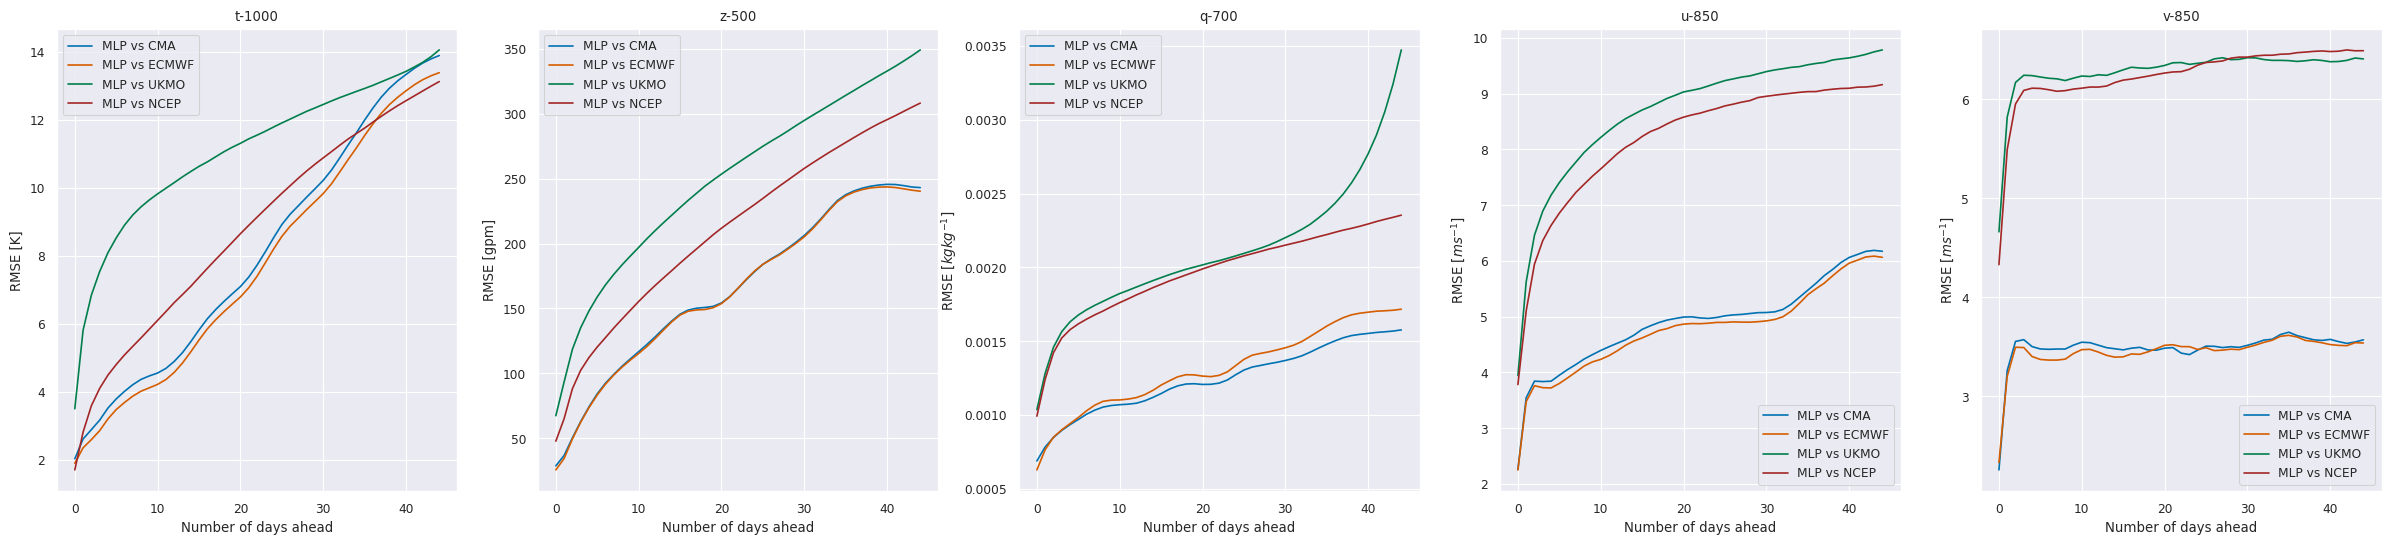

In [4]:
# Plot RMSE over time, across centers
s2s_names = list(config.S2S_CENTERS.keys())
headline_vars = dict({'t-1000': 'K', 'z-500': 'gpm', 'q-700': r'$kg kg^{-1}$', 'u-850': r'$ms^{-1}$', 'v-850': r'$ms^{-1}$'})
colors = list(['#0072B2', '#D55E00', '#007F4C', '#A32727'])

f, ax = plt.subplots(1, len(headline_vars), figsize=(6 * len(headline_vars), 6))

for s2s_idx, s2s_name in enumerate(s2s_names):
    
    rmse_df = pd.read_csv(Path(f'../logs/mlp_s2s/eval/rmse_{s2s_name}.csv'))

    for headline_idx, (headline_var, headline_unit) in enumerate(headline_vars.items()):

        sns.lineplot(
            rmse_df[[headline_var]].to_numpy().squeeze(), 
            label=f'MLP vs {s2s_name.upper()}',
            color=colors[s2s_idx],
            ax=ax[headline_idx]
        )

        ax[headline_idx].set_xlabel('Number of days ahead')
        ax[headline_idx].set_ylabel(f'RMSE [{headline_unit}]')
        ax[headline_idx].set_title(f'{headline_var}')